# Example 3: Extended usage and output diagnostics

In this notebook, we demonstrate extended usage of `pyvbmc`. We will:
- show you how to continue optimization starting from the results of a previous run,
- show you how to save the results of optimization to disk, and
- explore running `pyvbmc` multiple times to validate a result

This notebook is Part 3 of a series of notebooks in which we present various example usages for VBMC with the `pyvbmc` package.

In [1]:
import numpy as np
import scipy.stats as scs
from pyvbmc.vbmc import VBMC

## 1. Convergence Diagnostics

For demonstration purposes, we will run VBMC with a restricted budget of function evaluations, insufficient to achieve convergence. Then we will inspect the output diagnostics, and resume optimization.

We use a higher-dimensional analogue of the same toy target function in Example 1, a broad [Rosenbrock's banana function](https://en.wikipedia.org/wiki/Rosenbrock_function) in $D = 4$.

In [2]:
D = 4  # A four-dimensional problem
prior_mu = np.zeros(D)
prior_var = 3 * np.ones(D)


def log_prior(theta):
    """Multivariate normal prior on theta."""
    cov = np.diag(prior_var)
    return scs.multivariate_normal(prior_mu, cov).logpdf(theta)

Of course, your likelihood will in general depend on the observed data. This data can be fixed as a global variable, as we did above for `prior_mu` and `prior_var`. It can also be defined by a default keyword argument: to `pyvbmc` there is no difference so long as the function can be called with only a single argument (the parameters `theta`):

In [3]:
def log_likelihood(theta, data=np.ones(D)):
    """D-dimensional Rosenbrock's banana function."""
    # In this simple demo the data just translates the parameters:
    theta = np.atleast_2d(theta)
    theta = theta + data

    x, y = theta[:, :-1], theta[:, 1:]
    return -np.sum((x**2 - y) ** 2 + (x - 1) ** 2 / 100, axis=1)


def log_joint(theta, data=np.ones(D)):
    return log_likelihood(theta, data) + log_prior(theta)

In [4]:
LB = np.full(D, -np.inf)  # Lower bounds
UB = np.full(D, np.inf)  # Upper bounds
PLB = np.full(D, prior_mu - np.sqrt(prior_var))  # Plausible lower bounds
PUB = np.full(D, prior_mu + np.sqrt(prior_var))  # Plausible upper bounds

In a typical inference scenario, we recommend starting from a "good" point (i.e. one near the mode). We can run a  quick preliminary optimization (though a more extensive optimization would not harm).

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
x0 = np.random.uniform(PLB, PUB)  # Random point inside plausible box
x0 = minimize(lambda t: -log_joint(t), x0).x

In [6]:
# Limit number of function evaluations
options = {
    "max_fun_evals": 10 * D,
}
# We can specify either the log-joint, or the log-likelihood and log-prior.
# In other words, the following lines are equivalent:
vbmc = VBMC(
    log_likelihood,
    x0,
    LB,
    UB,
    PLB,
    PUB,
    user_options=options,
    log_prior=log_prior,
)
# vbmc = VBMC(
#     log_joint,
#     x0, LB, UB, PLB, PUB, user_options=options,
# )

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).


Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -9.40         4.43     28517.14        2        inf     start warm-up


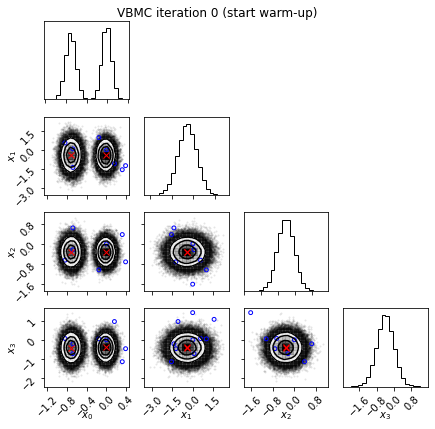

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     1         15          -5.28         1.89         8.77        2        inf     


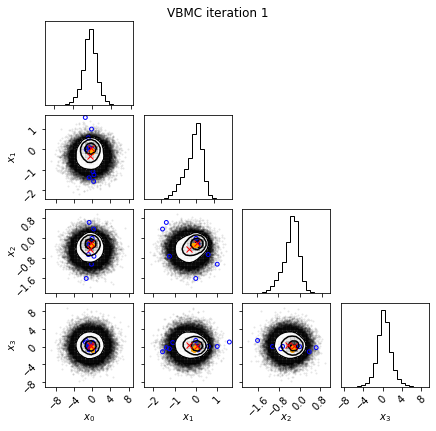

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     2         20          -5.44         0.64         5.29        2       90.8     


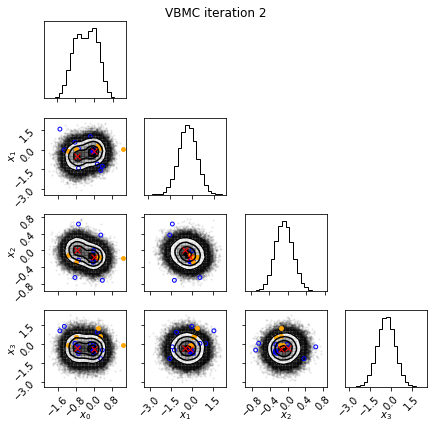

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     3         25          -4.92         1.50         3.07        2       57.8     


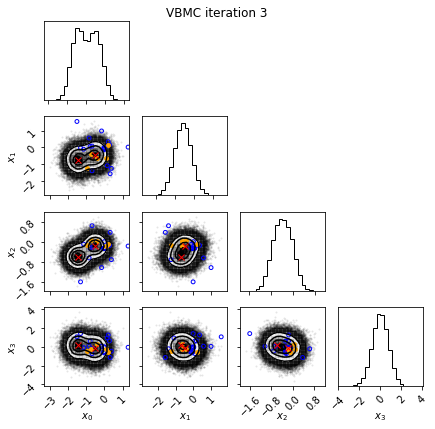

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     4         30          -5.30         0.37         0.60        2       12.4     end warm-up


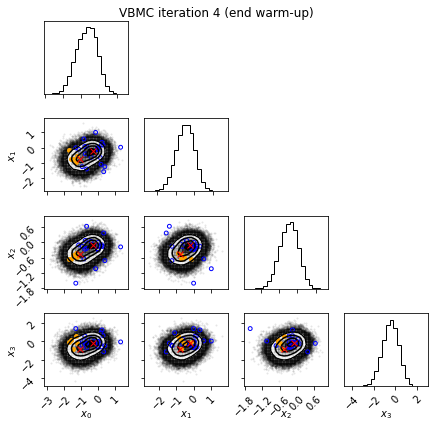

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     5         35          -4.72         0.50         0.65        2       14.5     


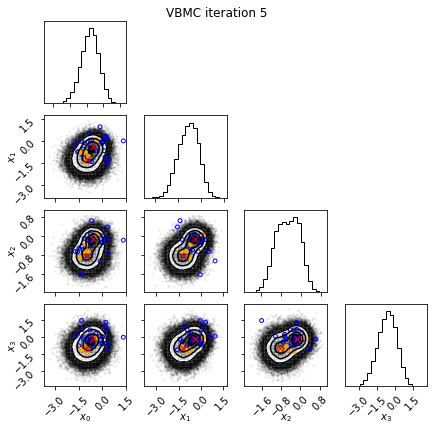

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     6         40          -4.85         0.22         0.11        2       3.04     


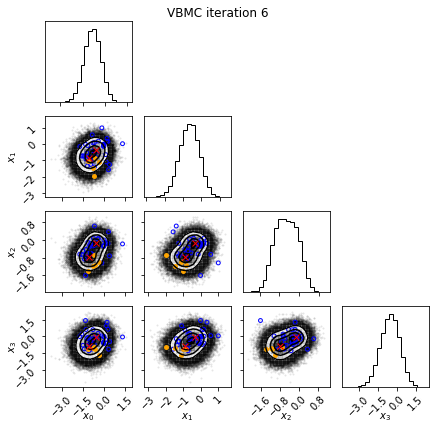

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
   inf         40          -4.62         0.20         0.14       50       3.04     finalize


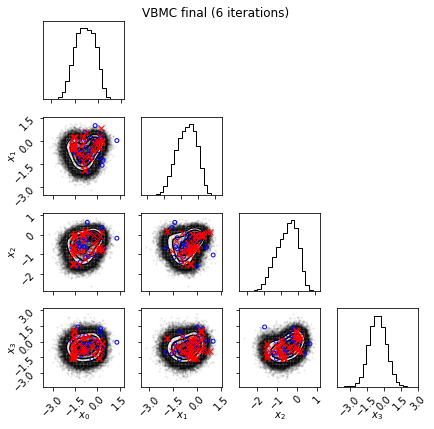

Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -4.623 +/-0.204.
Caution: Returned variational solution may have not converged.


In [7]:
vp, elbo, elbo_sd, success_flag, info = vbmc.optimize()

`pyvbmc` is warning us that convergence is doubtful. We can look at the output for more information and diagnostics.

In [8]:
success_flag

False

`False` means that `pyvbmc` has not converged to a stable solution within the given number of function evaluations.

In [9]:
info

{'function': '<function VBMC.__init__.<locals>.log_joint at 0x7f9a50b60940>',
 'problemtype': 'unconstrained',
 'iterations': 6,
 'funccount': 40,
 'bestiter': 6,
 'trainsetsize': 39,
 'components': 50,
 'rindex': 3.042736928327035,
 'convergencestatus': 'no',
 'overhead': nan,
 'rngstate': 'rng',
 'algorithm': 'Variational Bayesian Monte Carlo',
 'version': '0.0.1',
 'message': 'Inference terminated: reached maximum number of function evaluations options.max_fun_evals.',
 'elbo': -4.622726041730931,
 'elbo_sd': 0.2035135970346459}

In the `info` dictionary:
- the `convergencestatus` field says 'no' (probable lack of convergence);
- the reliability index `rindex` is 3.68, (should be less than 1).
Our diagnostics tell us that this run has not converged, suggesting to increase the budget. Note that convergence to a solution does not mean that it is a _good_ solution. You should always check the returned variational posteriors, and ideally should compare across multiple runs of `pyvbmc`.

## Continuing optimization from a previous result

We can continue running `pyvbmc` where we left off by calling the `optimize()` method again. But first we will change the function evaluation budget to a more realistic value.

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         50          -5.83         0.39         0.55        2        inf     


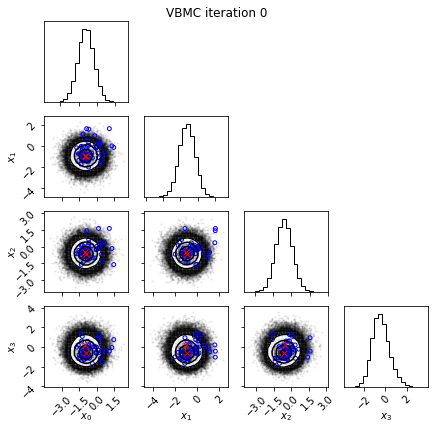

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     1         55          -4.62         0.13         0.36        3        inf     


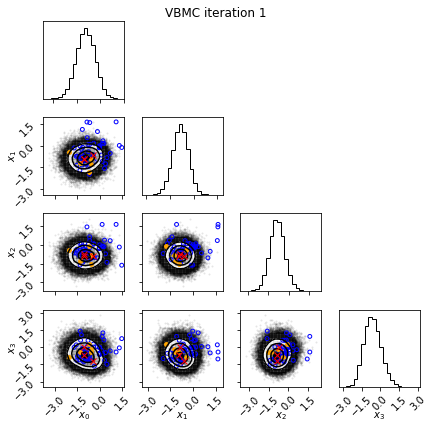

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     2         60          -4.49         0.03         0.31        4       5.73     


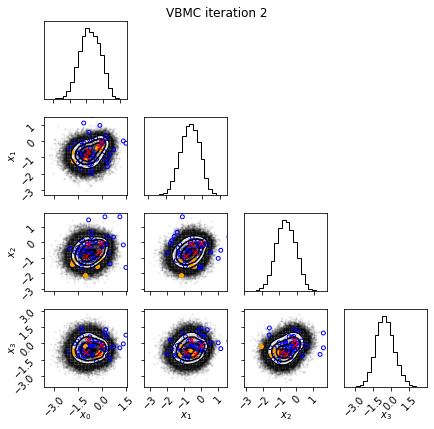

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     3         65          -4.44         0.01         0.03        4      0.647     


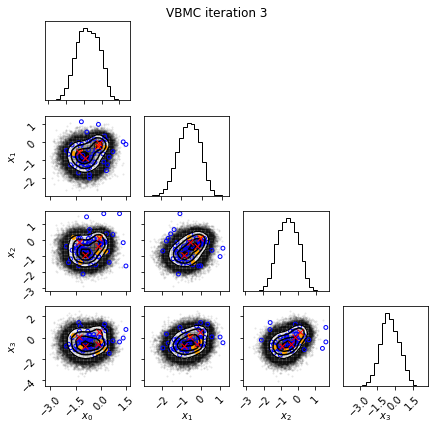

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     4         70          -4.40         0.01         0.03        4      0.674     


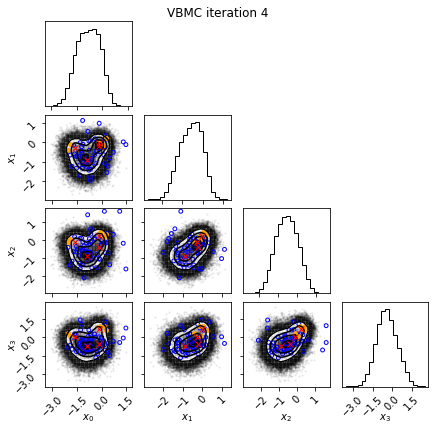

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     5         75          -4.40         0.01         0.00        4     0.0566     


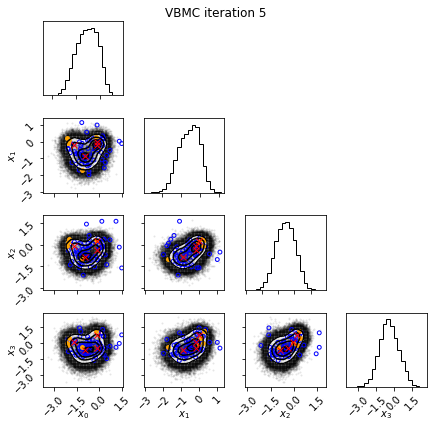

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     6         80          -4.40         0.00         0.00        4     0.0418     


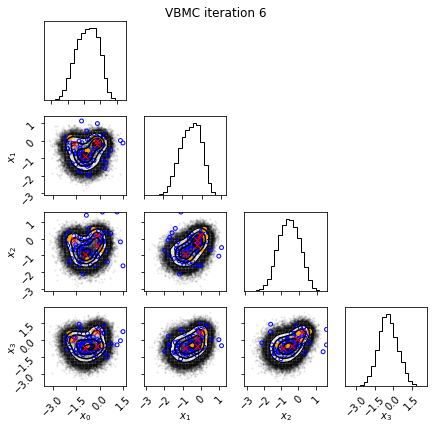

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     7         85          -4.39         0.00         0.00        4     0.0458     


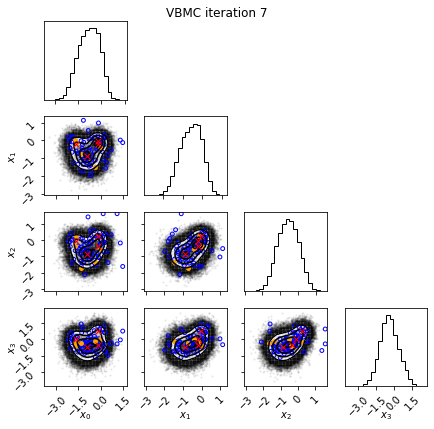

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     8         90          -4.36         0.00         0.01        7      0.251     


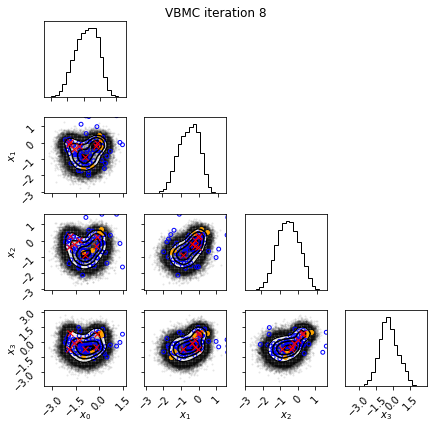

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     9         95          -4.33         0.00         0.00       10      0.158     rotoscale, undo rotoscale


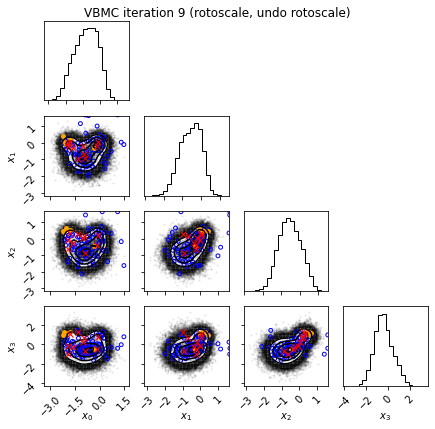

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    10        100          -4.30         0.00         0.00       13       0.17     


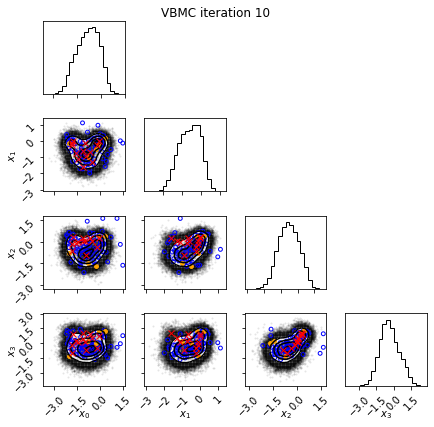

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    11        105          -4.28         0.00         0.01       16      0.223     


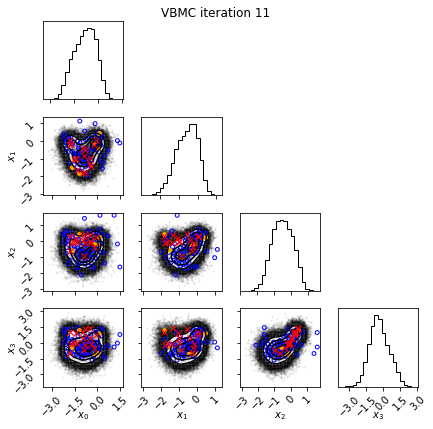

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    12        110          -4.26         0.00         0.00       19      0.112     stable


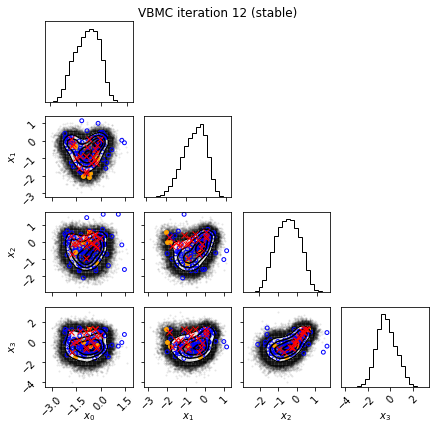

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
   inf        110          -4.20         0.00         0.01       50      0.112     finalize


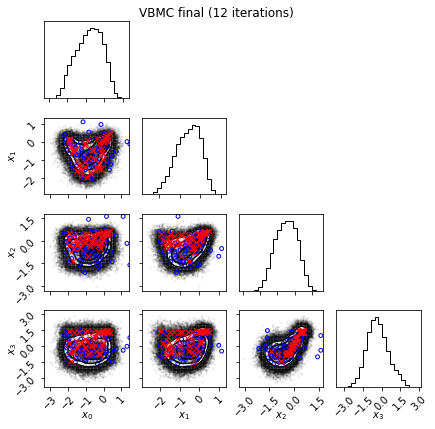

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4.199 +/-0.001.


(<pyvbmc.variational_posterior.variational_posterior.VariationalPosterior at 0x7f9a4e3efd00>,
 -4.199325559478286,
 0.0014757609708566644,
 True,
 {'function': '<function VBMC.__init__.<locals>.log_joint at 0x7f9a50b60940>',
  'problemtype': 'unconstrained',
  'iterations': 12,
  'funccount': 110,
  'bestiter': 12,
  'trainsetsize': 109,
  'components': 50,
  'rindex': 0.1116443419221832,
  'convergencestatus': 'probable',
  'overhead': nan,
  'rngstate': 'rng',
  'algorithm': 'Variational Bayesian Monte Carlo',
  'version': '0.0.1',
  'message': 'Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.',
  'elbo': -4.199325559478286,
  'elbo_sd': 0.0014757609708566644})

In [10]:
# This explicit syntax is required to avoid unintentionally modifying
# options after initialization:
vbmc.options.__setitem__("max_fun_evals", 50 * (D + 2), force=True)
vbmc.optimize()

## 3. Saving results

We can also save the `VBMC` instance to disk and reload it later, in order to continue optimization, sample from the posterior, check the results, etc.

In [11]:
import dill

with open("vbmc_test_save.pkl", "wb") as f:
    dill.dump(vbmc, f)

In [12]:
with open("vbmc_test_save.pkl", "rb") as f:
    vbmc_2 = dill.load(f)
vbmc_2.vp.sample(5)

(array([[-1.80517073, -0.21787767, -0.78523527, -1.16387783],
        [-0.32259242, -0.59868095,  0.41095508,  0.70498055],
        [-0.70604793, -0.94267525, -0.88346795, -0.17107477],
        [ 0.0695403 , -0.81779786, -0.50710989, -0.76844445],
        [-0.33987797, -1.11347061, -0.38854145, -0.40909749]]),
 array([44,  3,  1,  2,  1]))

## 4. Multiple runs as validation

Practical example with multiple PyVBMC runs to validate results.

In [18]:
D = 2  # Back to 2-D, for speed of demonstration
prior_mu = np.zeros(D)
prior_var = 3 * np.ones(D)
LB = np.full(D, -np.inf)  # Lower bounds
UB = np.full(D, np.inf)  # Upper bounds
PLB = np.full(D, prior_mu - np.sqrt(prior_var))  # Plausible lower bounds
PUB = np.full(D, prior_mu + np.sqrt(prior_var))  # Plausible upper bounds

  2) Currently, VBMC does not support half-bounds, so we need to specify a finite upper bound (cannot be `inf`). We pick something very large according to our prior. However, do not go crazy here by picking something impossibly large, otherwise VBMC will likely fail.

In [14]:
UB = 10 * prior_tau  # Upper bounds

NameError: name 'prior_tau' is not defined

  3) Plausible bounds need to be meaningfully different from the hard bounds, so here we cannot set the plausible lower bounds `PLB = 0`. We follow the same strategy as the first example, by picking the top ~68% credible interval of the prior.

In [ ]:
PLB = scs.expon.ppf(0.159, scale=prior_tau)
PUB = scs.expon.ppf(0.841, scale=prior_tau)

### Choosing the starting point

Good practice is to initialize VBMC in a region of high posterior density.

- With no additional information, *uninformed* approaches to choose the starting point $\mathbf{x}_0$ include picking the mode of the prior, or, if you need multiple points, a random draw from the prior or a random point uniformly chosen inside the plausible box. None of these approaches is particularly recommended, though, especially when facing more difficult problems.
- It is generally better to adopt an *informed* starting point $\mathbf{x}_0$. A good choice is typically a point in the approximate vicinity of the mode of the posterior (no need to start exactly at the mode). Clearly, it is hard to know in advance the location of the mode, but a common approach is to run a few optimization steps on the target (starting from one of the uninformed options above).

For this example, we cheat and start in the proximity of the mode, exploiting our knowledge of the toy likelihood, for which we know the location of the maximum.

In [ ]:
x0 = np.ones((1, D))  # Optimum of the Rosenbrock function

## 3. Initialize and run inference

Finally, we initialize and run VBMC. 

### Output trace

In each iteration, the VBMC output trace prints the following information:

- `Iteration`: iteration number (starting from 0, which follows the initial design).
- `f-count`: total number of the `target` function evaluations so far.
- `Mean[ELBO]`: Estimated mean of the `elbo`.
- `Std[ELBO]`: Standard deviation of the estimated `elbo`.
- `sKL-iter[q]`: Gaussianized symmetrized [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the variational posterior in the previous and current iteration. In brief, a measure of how much the variational posterior $q$ changes between iterations.
- `K[q]`: Number of mixture components of the variational posterior.
- `Convergence`: A number that summarizes the stability of the current solution, by weighing various factors such as the change in the `elbo` and in the variational posterior across iterations, and the uncertainty in the `elbo`. Values (much) less than 1 correspond to a stable solution and thus suggest convergence of the algorithm.
- `Action`: Major actions taken by the algorithm in the current iteration. Common actions/events are: 
  - `start warm-up` and `end warm-up`: start and end of the initial warm-up stage;
  - `trim data`: some points are removed to increase stability;
  - `stable`: solution stable for multiple iteration;
  - `finalize`: refine the variational approximation with additional mixture components.

### Iteration plotting

In this example, we also switch on the plotting of the current variational posterior at each iteration with the user option `plot`. Regarding the iteration plots:

- Each iteration plot shows the multidimensional variational posterior in the current iteration via one- and two-dimensional marginal plots for each variable and pairs of variables, as you would get from `vp.plot()` (see also Example 1).
- In each plot, blue circles represent points in the training set, and orange dots are points added to the training set in this iteration. 
- The red crosses are the centers of the variational mixture components.
- Since VBMC with plotting on can occupy a lot of space on the notebook, remember that in Jupyter notebook you can toggle the scrolling on and off via the "Cell > Current Outputs > Toggle Scrolling" and "Cell > All Output > Toggle Scrolling" menus.

In [ ]:
# initialize VBMC
user_options = {"plot": True}
vbmc = VBMC(target, x0, LB, UB, PLB, PUB, user_options)

# run VBMC
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

In [ ]:
lml_true = -1.836  # ground truth, which we know for this toy scenario

print("The true log model evidence is:", lml_true)
print("The obtained ELBO is:", format(elbo, ".3f"))
print("The obtained ELBO_SD is:", format(elbo_sd, ".3f"))

## 4. Examine and visualize results

We will examine now the obtained variational posterior with an interactive plot.

*Note*: The interactive plot will not be visible in a notebook preview on GitHub. See below for a static image.

In [ ]:
# Generate samples from the variational posterior
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

# We compute the pdf of the approximate posterior on a 2-D grid
plot_lb = np.zeros(2)
plot_ub = np.quantile(Xs, 0.999, axis=0)
x1 = np.linspace(plot_lb[0], plot_ub[0], 400)
x2 = np.linspace(plot_lb[1], plot_ub[1], 400)

xa, xb = np.meshgrid(x1, x2)  # Build the grid
xx = np.vstack(
    (xa.ravel(), xb.ravel())
).T  # Convert grids to a vertical array of 2-D points
yy = vp.pdf(xx)  # Compute PDF values on specified points

In [ ]:
# Plot approximate posterior pdf (this interactive plot does not work in higher D)
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(z=yy.reshape(x1.size, x2.size), x=x1, y=x2, showscale=False)
    ]
)
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    scene=dict(
        xaxis_title="x_0",
        yaxis_title="x_1",
        zaxis_title="Approximate posterior pdf",
    ),
)

# Compute and plot approximate posterior mean
post_mean = np.mean(Xs, axis=0)
fig.add_trace(
    go.Scatter3d(
        x=[post_mean[0]],
        y=[post_mean[1]],
        z=vp.pdf(post_mean),
        name="Approximate posterior mean",
        marker_symbol="diamond",
    )
)

# Find and plot approximate posterior mode
# post_mode = vp.mode()
# fig.add_trace(go.Scatter3d(x=[post_mode[0]], y=[post_mode[1]], z=vp.pdf(post_mode), name="Approximate posterior mode", marker_symbol="x"))

In [ ]:
# Display posterior also as a non-interactive static image
from IPython.display import Image

Image(fig.to_image(format="png"))

## 5. Conclusions

In this notebook, we have discussed more in detail the input parameter settings (bounds and starting point) and the output trace of VBMC.

An important step still not considered in this example is a thorough validation of the results and diagnostics, which will be discussed in a later notebook.

## Example 2: full code

The following cell includes in a single place all the code used in Example 2, without the extra fluff.

In [ ]:
import numpy as np
import scipy.stats as scs
from pyvbmc.vbmc import VBMC

#####################################################################
# 1. Model definition: log likelihood, log prior, and log joint

D = 2  # still in 2-D

# log likelihood (Rosenbrock)
def llfun(x):
    x = np.atleast_2d(x)
    return -np.sum(
        (x[0, :-1] ** 2.0 - x[0, 1:]) ** 2.0 + (x[0, :-1] - 1) ** 2.0 / 100
    )


prior_tau = 3 * np.ones((1, D))  # Length scale of the exponential prior
lpriorfun = lambda x: np.sum(scs.expon.logpdf(x, scale=prior_tau))

target = lambda x: llfun(x) + lpriorfun(x)  # Log joint

#####################################################################
# 2. Parameter setup: bounds and starting point

LB = np.zeros((1, D))  # Lower bounds
UB = 10 * prior_tau  # Upper bounds
PLB = scs.expon.ppf(0.159, scale=prior_tau)
PUB = scs.expon.ppf(0.841, scale=prior_tau)

x0 = np.ones((1, D))  # Optimum of the Rosenbrock function

#####################################################################
# 3. Initialize and run inference

# initialize VBMC
user_options = {"plot": True}
vbmc = VBMC(target, x0, LB, UB, PLB, PUB, user_options)

# run VBMC
vp, elbo, elbo_sd, _, _ = vbmc.optimize()

lml_true = -1.836  # ground truth, which we know for this toy scenario
print("The true log model evidence is:", lml_true)
print("The obtained ELBO is:", format(elbo, ".3f"))
print("The obtained ELBO_SD is:", format(elbo_sd, ".3f"))

#####################################################################
# 4. Analyze and visualize results

# Generate samples from the variational posterior
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

# We compute the pdf of the approximate posterior on a 2-D grid
plot_lb = np.zeros(2)
plot_ub = np.quantile(Xs, 0.999, axis=0)
x1 = np.linspace(plot_lb[0], plot_ub[0], 400)
x2 = np.linspace(plot_lb[1], plot_ub[1], 400)

xa, xb = np.meshgrid(x1, x2)  # Build the grid
xx = np.vstack(
    (xa.ravel(), xb.ravel())
).T  # Convert grids to a vertical array of 2-D points
yy = vp.pdf(xx)  # Compute PDF values on specified points

# Plot approximate posterior pdf (this interactive plot does not work in higher D)
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(z=yy.reshape(x1.size, x2.size), x=x1, y=x2, showscale=False)
    ]
)
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    scene=dict(
        xaxis_title="x_0",
        yaxis_title="x_1",
        zaxis_title="Approximate posterior pdf",
    ),
)

# Compute and plot approximate posterior mean
post_mean = np.mean(Xs, axis=0)
fig.add_trace(
    go.Scatter3d(
        x=[post_mean[0]],
        y=[post_mean[1]],
        z=vp.pdf(post_mean),
        name="Approximate posterior mean",
        marker_symbol="diamond",
    )
)

# Find and plot approximate posterior mode
# post_mode = vp.mode()
# fig.add_trace(go.Scatter3d(x=[post_mode[0]], y=[post_mode[1]], z=vp.pdf(post_mode), name="Approximate posterior mode", marker_symbol="x"))

# Display posterior also as a non-interactive static image
from IPython.display import Image

Image(fig.to_image(format="png"))

## Acknowledgments

Work on the `pyvbmc` package was funded by the [Finnish Center for Artificial Intelligence FCAI](https://fcai.fi/).